# E-Gamma Only
## Run Details:
- Dataset: 
- Test Goals: 
- Results Summary: 

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm
from repeating_classifier_training_utils import *

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

## Set Run Directories Here

In [2]:
dump_dir = '/home/cmacdonald/CNN/dumps/'

paths = ['20200717_183009_no_muons','20200720_135853_no_muons_lr00002','20200721_101347_no_muons_bs32',
         '20200731_151811_egamma_transforms_train','20200803_165134_no_muons_bs32_transforms',
         '20200804_173549_no_muons_rn34','20200806_173844_egamma_fulldset_notransforms',
         '20200808_102346_egamma_fulldset_transforms', '20200810_155502_egamma18_fulldset_transforms',
         '20200814_180556_egamma_tweaks','20200824_122650_egamma_odvetoed']
preferred_run_idx = 6
paths = [os.path.join(dump_dir, path) for path in paths]
run_names=['LR1e-4, BS 512','LR2e-5, BS 512', 'LRe-4, BS 32', 'LRe-4, BS512, Transforms', 
           'LRe-4, BS32, Transforms', 'LRe-4, BS512, Transforms,\n RN34', 'Full DSet, No Transforms \n RN34',
          'Full Dset, Transforms \n RN34', 'Full Dset, Transforms, RN18', 'Tweaks','Full Dset, Transforms, OD Veto']
cut_names=[['fq_failed', 'fq_flag'] for _ in range(11)]

idx_file_paths = ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_no_muons.npz' for _ in range(4)]
idx_file_paths.append('/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_pe_idxs_no_muons.npz')
idx_file_paths.append('/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_pe_idxs_no_muons.npz')
idx_file_paths=idx_file_paths+['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_extra_nomuons.npz' for _ in range(4)]
idx_file_paths.append('/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_pe_idxs_extra_nomuons.npz')
npz_path = os.path.join(os.getcwd(),'Index_Storage')

LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
legend_label_dict = {'gamma':'\u03B3','e':'e-','mu':'\u03BC-'}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

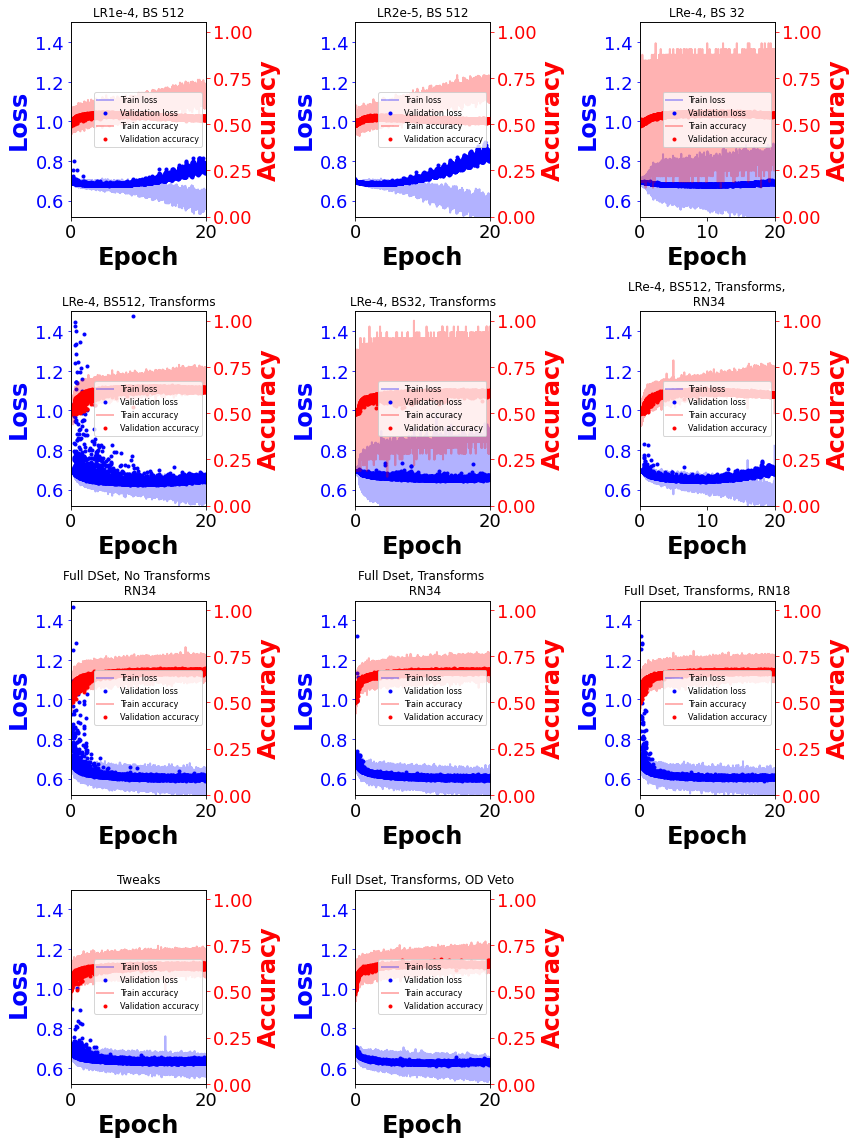

In [3]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=run_names,leg_font=8, title_font=12)

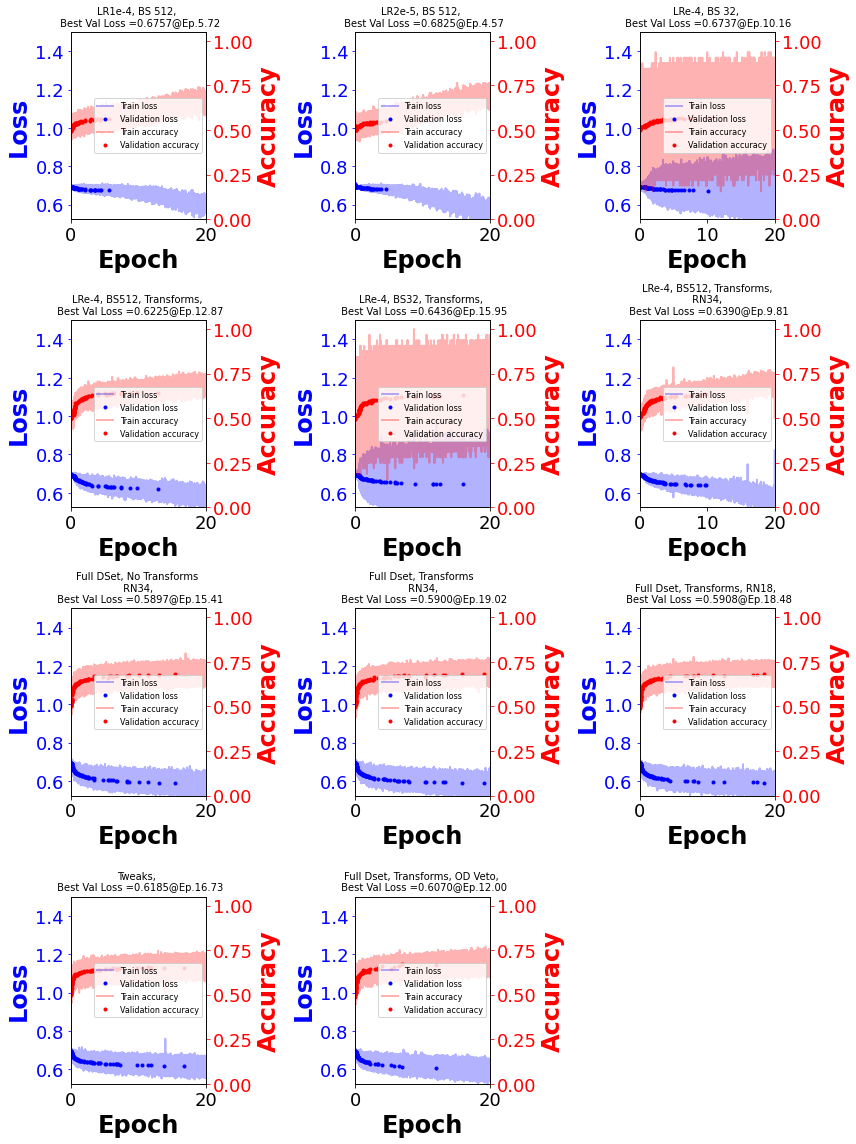

In [4]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=run_names,leg_font=8, title_font=10, best_only=True)

## Plot Confusion Matrices

In [5]:
paths[3] = os.path.join(dump_dir, '20200803_120925_egamma_transforms_test')

In [6]:
test_output = [load_test_output_pn(os.path.join(loc,'test_validation_iteration_dump.npz'),os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),np.load(idx_file_paths[i])['test_idxs'], cut_names[i]) 
               for i,loc in enumerate(paths)]

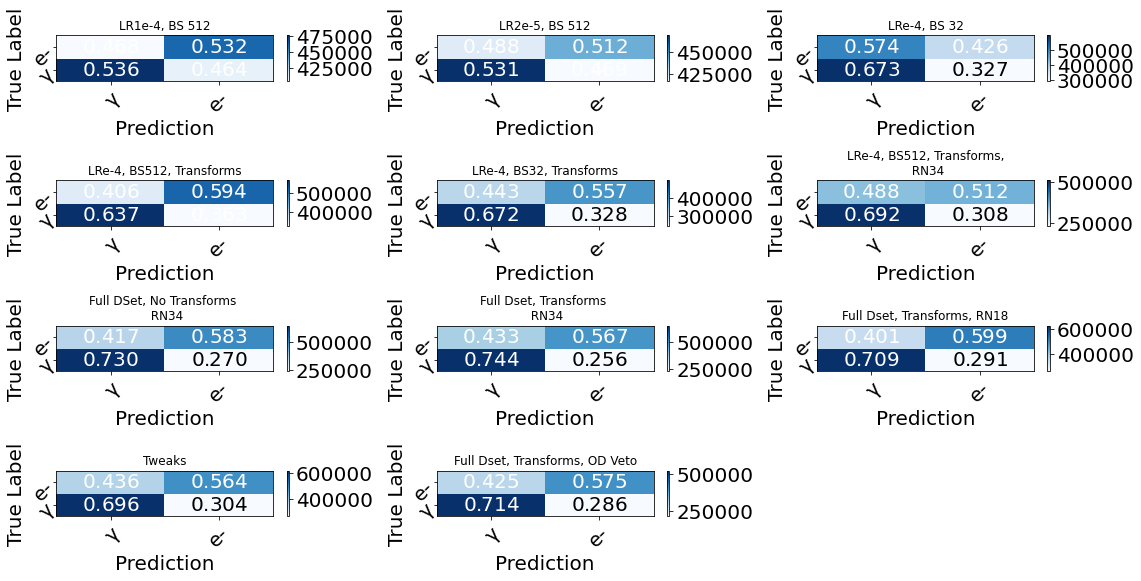

In [7]:
fig = plot_multiple_confusion_matrix([output['labels'] for output in test_output], [output['predicted_labels'] for output in test_output],
                               ['\u03B3','e-'],titles=run_names)

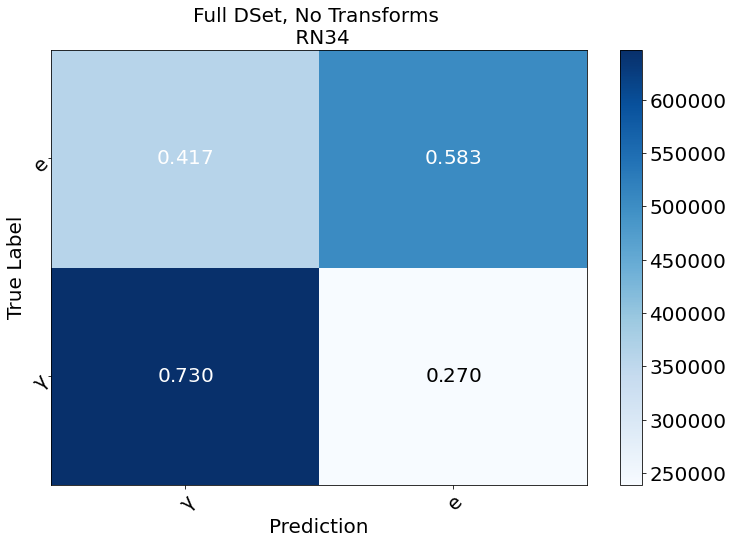

In [8]:
preferred_run=test_output[preferred_run_idx]
plot_confusion_matrix(preferred_run['labels'],preferred_run['predicted_labels'],['\u03B3','e'],title=run_names[preferred_run_idx])


In [9]:
print(f"Number of e- events: {len(np.where(test_output[-1]['labels']==1)[0])} gamma events: {len(np.where(test_output[-1]['labels']==0)[0])}")

Number of e- events: 708251 gamma events: 735030


## ROC Curves

In [10]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection',softmax_index_dict,"e","gamma",energies=output['energies'],) for output in test_output]
                            )

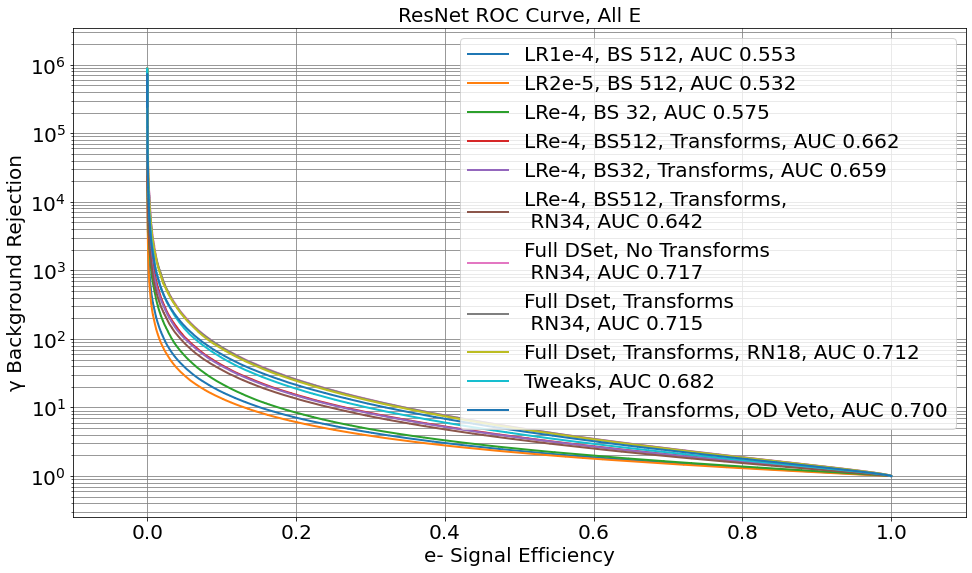

In [11]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False, legend_label_dict=legend_label_dict)

In [12]:
fq_rootfiles, fq_eventids, fq_flag, fq_scores, fq_mom, fq_labels = load_fq_output(os.path.join(npz_path,'fq_mapping_idxs.npz'), os.path.join(npz_path,'fq_failed_idxs.npz'), idx_file_paths[0], os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'), cut_names[0])

In [13]:
pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(fq_rootfiles))
pbar.start()
for i in range(len(fq_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == preferred_run['rootfiles'][i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i] -1 == preferred_run['eventids'][i]
    pbar.update(i)
pbar.finish()
assert len(preferred_run['rootfiles']) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

Success! We now have a FiTQun output set in the same order as the h5 test set


In [14]:
fprs, tprs, thresholds = zip(*[prep_roc_data(preferred_run['softmax'],preferred_run['labels'],
                                'rejection',softmax_index_dict,"e","gamma"),
                               prep_roc_data(fq_scores,fq_labels,
                                'rejection',softmax_index_dict,"e","gamma")                               
                              ]
                            )

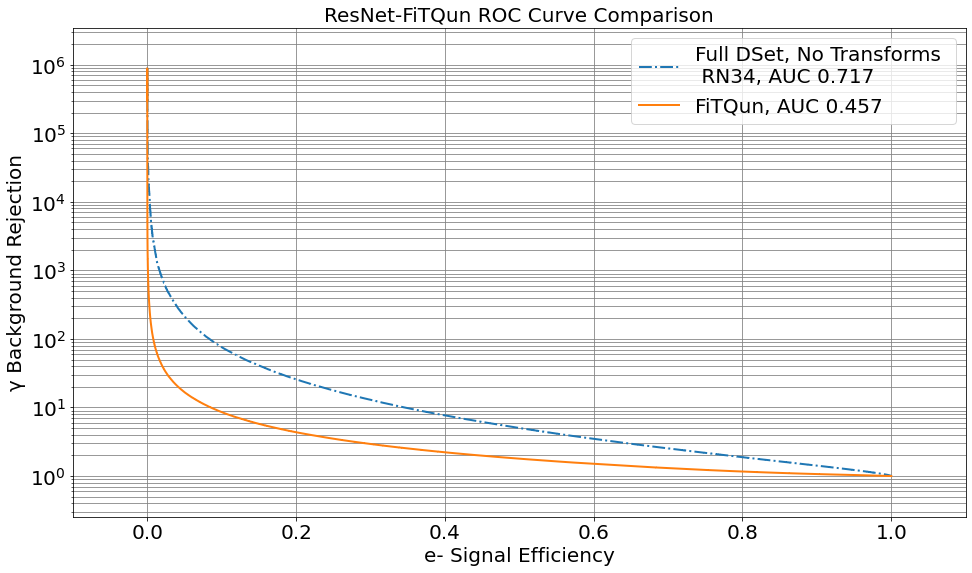

In [15]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "gamma"],["e", 'gamma']], 
                                plot_labels = [f'{run_names[preferred_run_idx]}','FiTQun'],
                                png_name = 'overlaid_roc',title='ResNet-FiTQun ROC Curve Comparison',annotate=False,
                                linestyle=('dashdot','-','--'), xlabel='e- Signal Efficiency',ylabel='\u03B3 Background Rejection', legend_label_dict=legend_label_dict)
# plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison.pdf'))

In [16]:
fractions, tprs, fprs, thresholds = zip(*[prep_roc_data(preferred_run['softmax'],preferred_run['labels'],
                                'fraction',softmax_index_dict,"e","gamma"),
                                prep_roc_data(fq_scores,fq_labels,'fraction',softmax_index_dict,"e","gamma")]
                            )

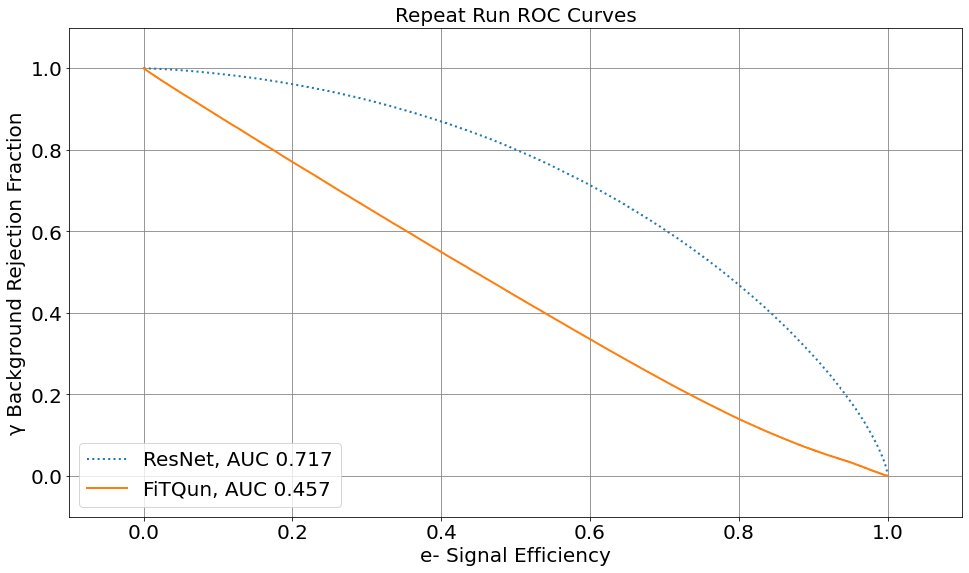

In [17]:
roc_metrics = plot_multiple_ROC((fractions, tprs, fprs, thresholds),'fraction', [["e", "gamma"],['e','gamma'],['e','mu']], 
                                plot_labels = ['ResNet','FiTQun'],
                                png_name = 'overlaid_roc',title='Repeat Run ROC Curves',annotate=False,linestyle=(':','-','--','dashdot'),
                                leg_loc='lower left', legend_label_dict=legend_label_dict)
plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison_fraction.pdf'))

## Signal Purity vs Energy At Fixed Efficiency

In [18]:
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26
f=h5py.File('/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5', 'r')
energies=np.array(f['energies'])
labels=np.array(f['labels'])

for i, run in enumerate(test_output):
    shifted_energies = []
    
    idxs = np.load(idx_file_paths[i],allow_pickle=True)['test_idxs']
    run_labels=labels[idxs]
    run_energies=energies[idxs]
    
    shifted_energies = np.zeros(run_labels.shape[0])
    
    g_idxs = np.where(run_labels==0)[0]
    e_idxs = np.where(run_labels==1)[0]
    m_idxs = np.where(run_labels==2)[0]
    shifted_energies[g_idxs] = np.squeeze(run_energies[g_idxs] - GAMMA_THRESHOLD)
    shifted_energies[e_idxs] = np.squeeze(run_energies[e_idxs] - ELECTRON_THRESHOLD)
    shifted_energies[m_idxs] = np.squeeze(run_energies[m_idxs] - MUON_THRESHOLD)
    run['shifted_energies'] = apply_cuts(shifted_energies, idxs, os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'), cut_names[i])

In [19]:
shifted_energies = []
    
idxs = np.load(idx_file_paths[0],allow_pickle=True)['test_idxs']
run_labels=labels[idxs]
run_energies=energies[idxs]

shifted_energies = np.zeros(run_labels.shape[0])

g_idxs = np.where(run_labels==0)[0]
e_idxs = np.where(run_labels==1)[0]
m_idxs = np.where(run_labels==2)[0]
shifted_energies[g_idxs] = np.squeeze(run_energies[g_idxs] - GAMMA_THRESHOLD)
shifted_energies[e_idxs] = np.squeeze(run_energies[e_idxs] - ELECTRON_THRESHOLD)
shifted_energies[m_idxs] = np.squeeze(run_energies[m_idxs] - MUON_THRESHOLD)
fq_shifted_energies = apply_cuts(shifted_energies, idxs, os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'), cut_names[0])

/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:958: RuntimeWarning: divide by zero encountered in true_divide
  elif metric == 'inverse fpr': performance = np.where(fps != 0, (fps +tns) / fps, fps+tns)


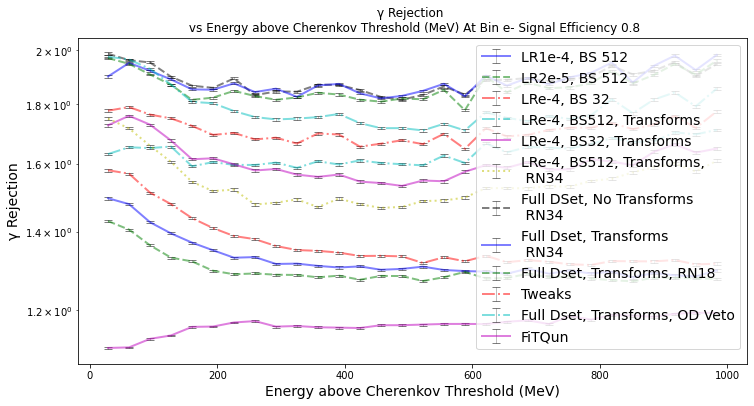

In [20]:
##Binning in Energy
scores = [run['softmax'] for run in test_output]
labels = [run['labels'] for run in test_output]
binning_features = [run['shifted_energies'] for run in test_output]
feature_label = 'Energy above Cherenkov Threshold (MeV)'
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
style = ['-','--','-.','-.','-',':','--']

fig, ax = plt.subplots(figsize=(12,6))

for i, softmax in enumerate(scores):
    plot_binned_performance(softmax,
            labels[i],
            binning_features[i],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='inverse fpr',marker=style[i%7],color=colors[i%7],ax=ax,title_note='' , legend_label_dict=legend_label_dict) 

plot_binned_performance(fq_scores,
            fq_labels,
            fq_shifted_energies,           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='inverse fpr',marker=style[len(scores)%7],color=colors[len(scores)%7],ax=ax,title_note='' , legend_label_dict=legend_label_dict)

ax.legend(run_names+['FiTQun'],fontsize=14)

In [21]:
#Binning in origin radius squared
d_to_wall_incl_all = np.load('dist_to_wall.npz')['test_d_to_wall']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

idx_dic = {}
for i, idx in enumerate(test_filtered_indices):
    idx_dic[idx] = i

test_idxs_list = [np.load(idx_file_path, allow_pickle=True)['test_idxs'] for idx_file_path in idx_file_paths]

keep_idxs_list = []

for test_idxs in test_idxs_list:
    keep_idxs = []
    for idx in test_idxs:
        try:
            keep_idxs.append(idx_dic[idx])
        except KeyError:
            pass
    keep_idxs_list.append(keep_idxs)

dtowall_list = [apply_cuts(d_to_wall_incl_all[keep_idxs], test_idxs_list[i], os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),cut_names[i]) for i, keep_idxs in enumerate(keep_idxs_list)]

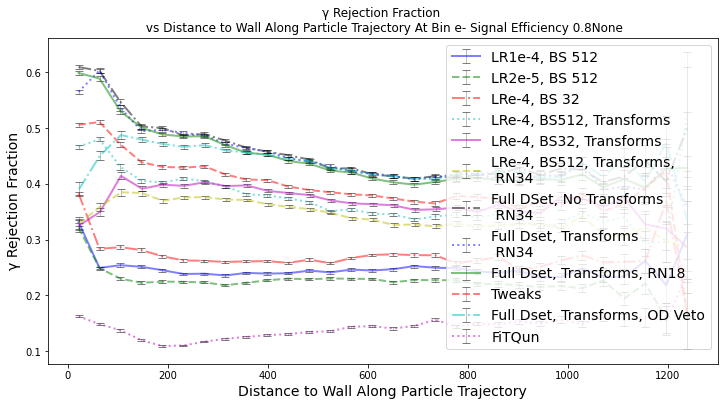

In [22]:
scores = [run['softmax'] for run in test_output]
labels = [run['labels'] for run in test_output]
binning_features = [dtowall for dtowall in dtowall_list]
feature_label = 'Distance to Wall Along Particle Trajectory'
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
style = ['-','--','-.',':']

fig, ax = plt.subplots(figsize=(12,6))

for i, softmax in enumerate(scores):
    plot_binned_performance(softmax,
            labels[i],
            binning_features[i],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='rejection',marker=style[i%4],color=colors[i%7],ax=ax,title_note=None , legend_label_dict=legend_label_dict) 

plot_binned_performance(fq_scores,
            fq_labels,
            binning_features[0],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='rejection',marker=style[len(scores)%4],color=colors[len(scores)%7],ax=ax,title_note=None, legend_label_dict=legend_label_dict ) 
    
ax.legend(run_names+['FiTQun'],fontsize=14)

In [23]:
#Binning in origin radius squared
test_radius_incl_all = np.load('event_radii.npz')['test_radii']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

idx_dic = {}
for i, idx in enumerate(test_filtered_indices):
    idx_dic[idx] = i


test_idxs_list = [np.load(idx_file_path, allow_pickle=True)['test_idxs'] for idx_file_path in idx_file_paths]

keep_idxs_list = []

for test_idxs in test_idxs_list:
    keep_idxs = []
    for idx in test_idxs:
        try:
            keep_idxs.append(idx_dic[idx])
        except KeyError:
            pass
    keep_idxs_list.append(keep_idxs)

test_radius_list = [apply_cuts(test_radius_incl_all[keep_idxs], test_idxs_list[i], os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),cut_names[i]) for i, keep_idxs in enumerate(keep_idxs_list)]

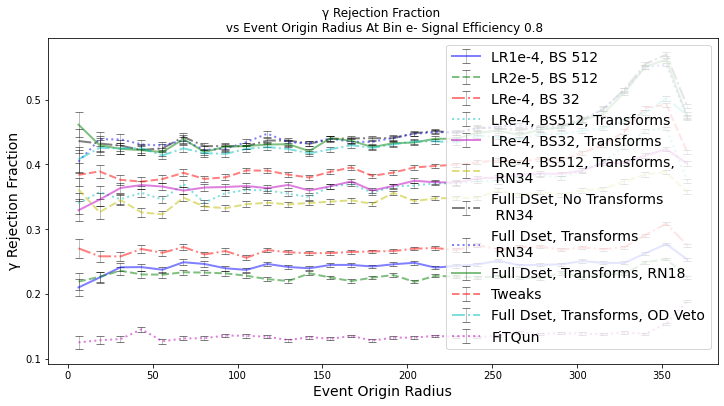

In [24]:
scores = [run['softmax'] for run in test_output]
labels = [run['labels'] for run in test_output]
binning_features = [test_radius for test_radius in test_radius_list]
feature_label = 'Event Origin Radius'
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
style = ['-','--','-.',':']

fig, ax = plt.subplots(figsize=(12,6))

for i, softmax in enumerate(scores):
    plot_binned_performance(softmax,
            labels[i],
            binning_features[i],           
            feature_label,
            0.8, 30, softmax_index_dict, 'e','gamma',metric='rejection',marker=style[i%4],color=colors[i%7],ax=ax,title_note=None , legend_label_dict=legend_label_dict) 

plot_binned_performance(fq_scores,
    fq_labels,
    binning_features[0],           
    feature_label,
    0.8, 30, softmax_index_dict, 'e','gamma',metric='rejection',marker=style[len(scores)%4],color=colors[len(scores)%7],ax=ax , legend_label_dict=legend_label_dict)

ax.legend(run_names+['FiTQun'],fontsize=14)

## Plot Classifier Response

/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


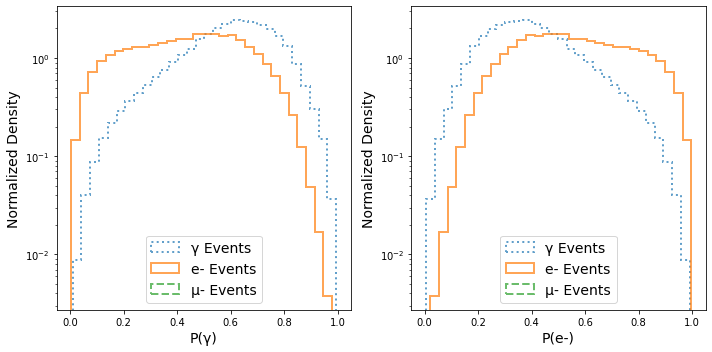

In [25]:
fig=plot_response(preferred_run['softmax'], preferred_run['labels'], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['lower center', 'lower center', 'upper center',
                                                                                    'upper center'], legend_label_dict=legend_label_dict)
plt.savefig(os.path.join(os.getcwd(),'plot_images/resnet_response.pdf'))

In [26]:
ns,bins = np.histogram(preferred_run['shifted_energies'], bins=5)
left_edges = bins[0:-1]
bin_assignments = np.digitize(preferred_run['shifted_energies'], left_edges)

/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  retur

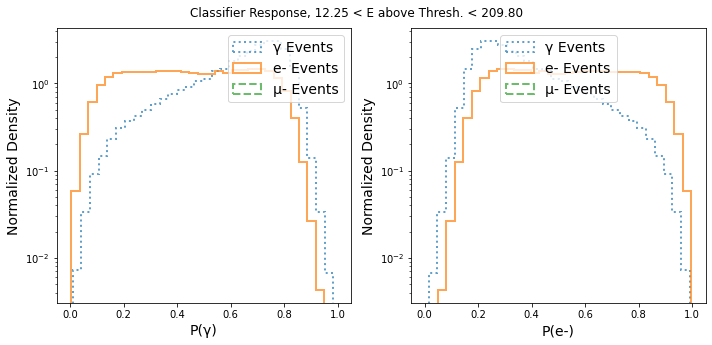

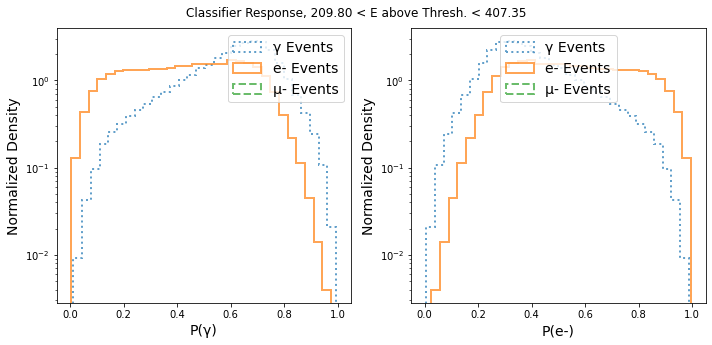

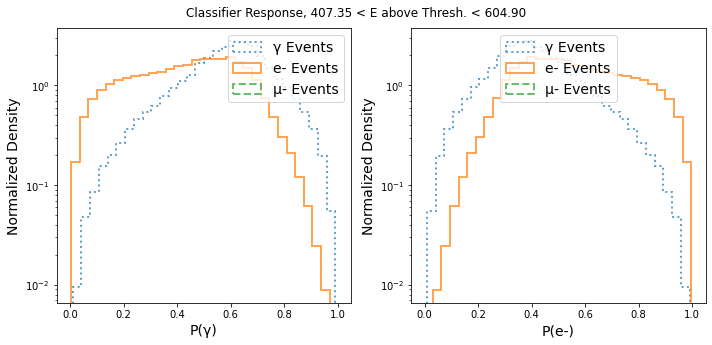

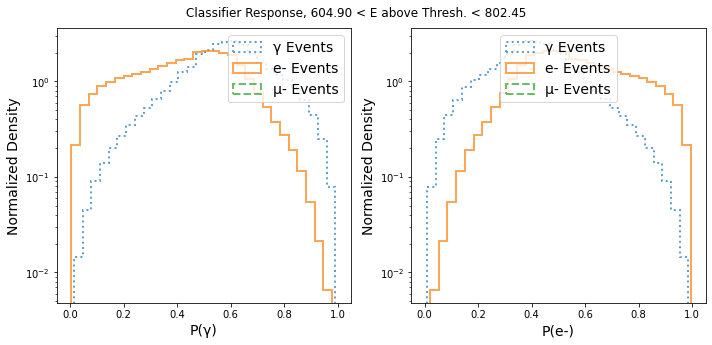

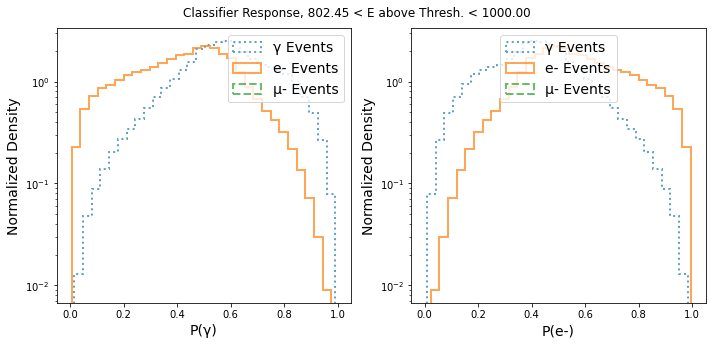

In [27]:
for BIN_NUM in range(1,6):
    bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
    fig = plot_response(preferred_run['softmax'][bin_idxs,:], preferred_run['labels'][bin_idxs], ['gamma','e','mu'], 
                        softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                        'upper center'], legend_label_dict=legend_label_dict)
    a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(os.getcwd(),f'plot_images/resnet_1d_binned_response_bin{BIN_NUM}.pdf'))

In [28]:
for i in range(fq_labels.shape[0]):
    assert fq_labels[i] == preferred_run['labels'][i]
assert fq_labels.shape[0] == preferred_run['labels'].shape[0]

## Plot Binned Response

In [29]:
binning_features = [preferred_run['shifted_energies'], test_radius_list[preferred_run_idx]**2, dtowall_list[preferred_run_idx]]
binning_labels=['Energy above Cherenkov Threshold (MeV)','Radius Squared of Event Origin (cm^2)',
                'Trajectory Distance to Wall (cm)']

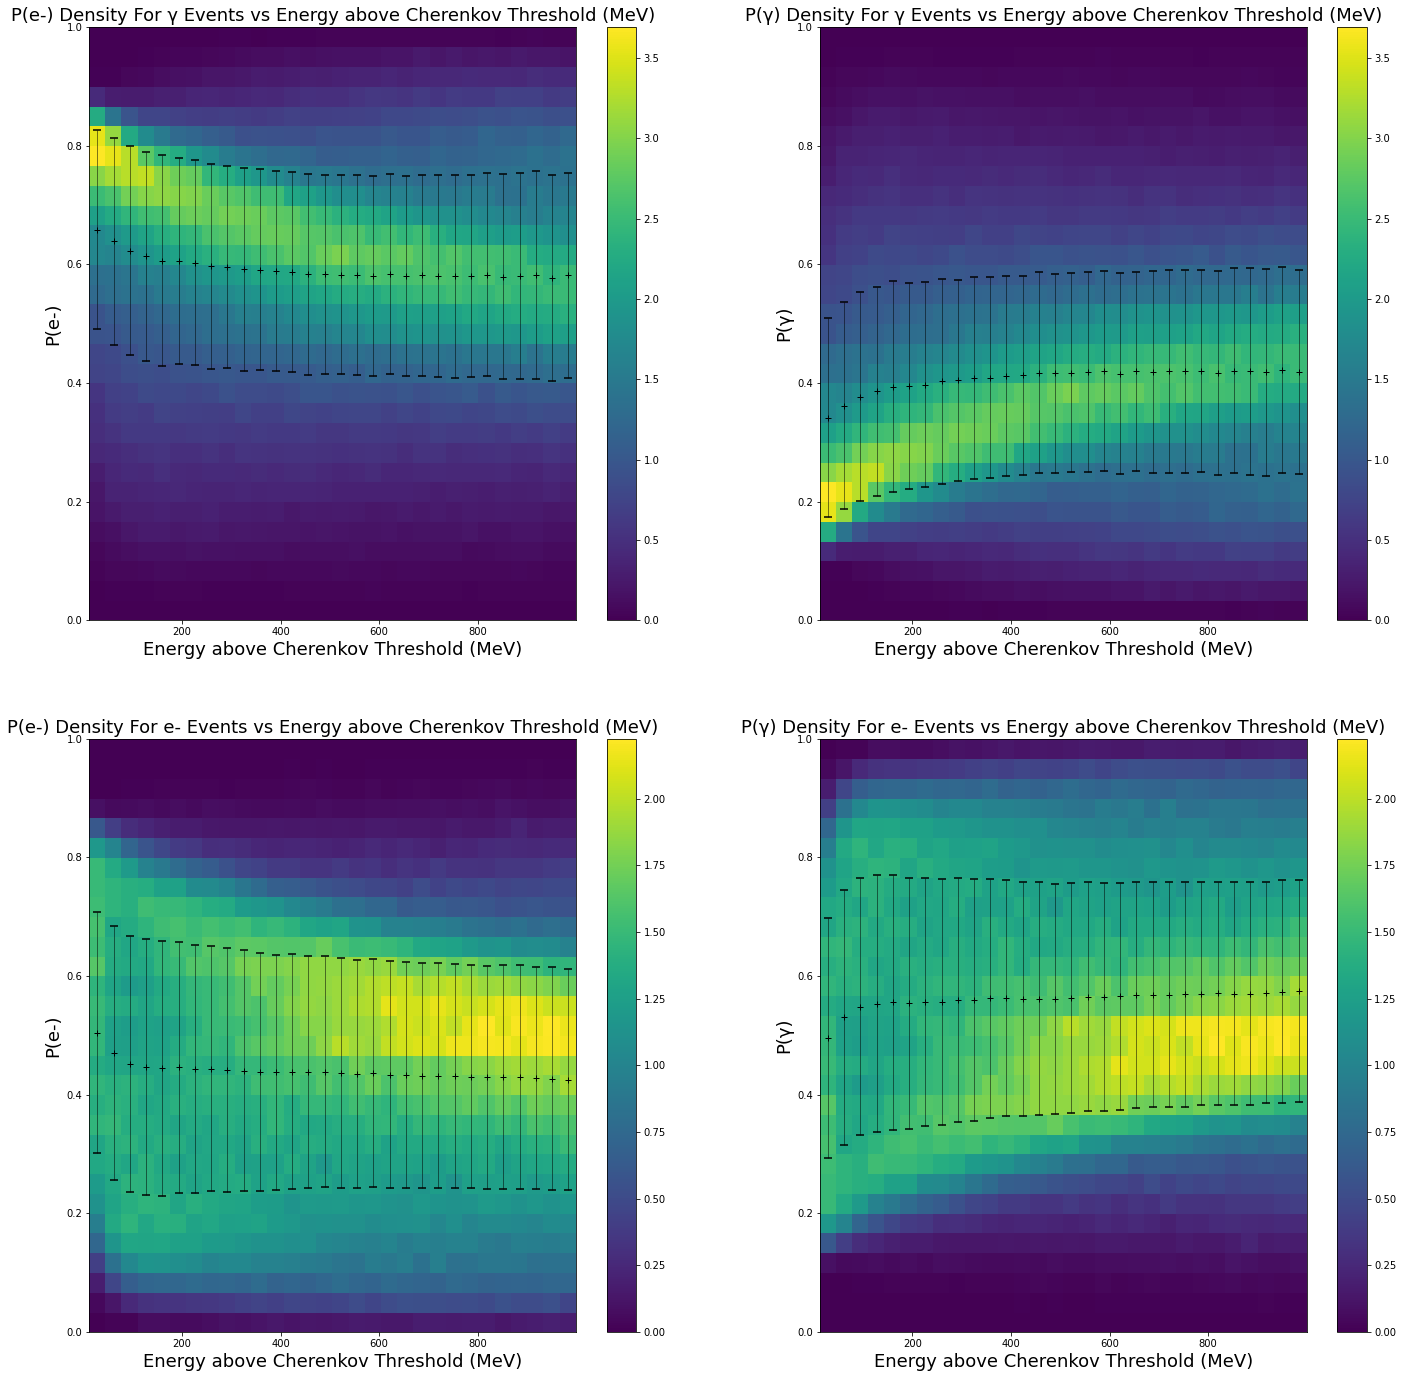

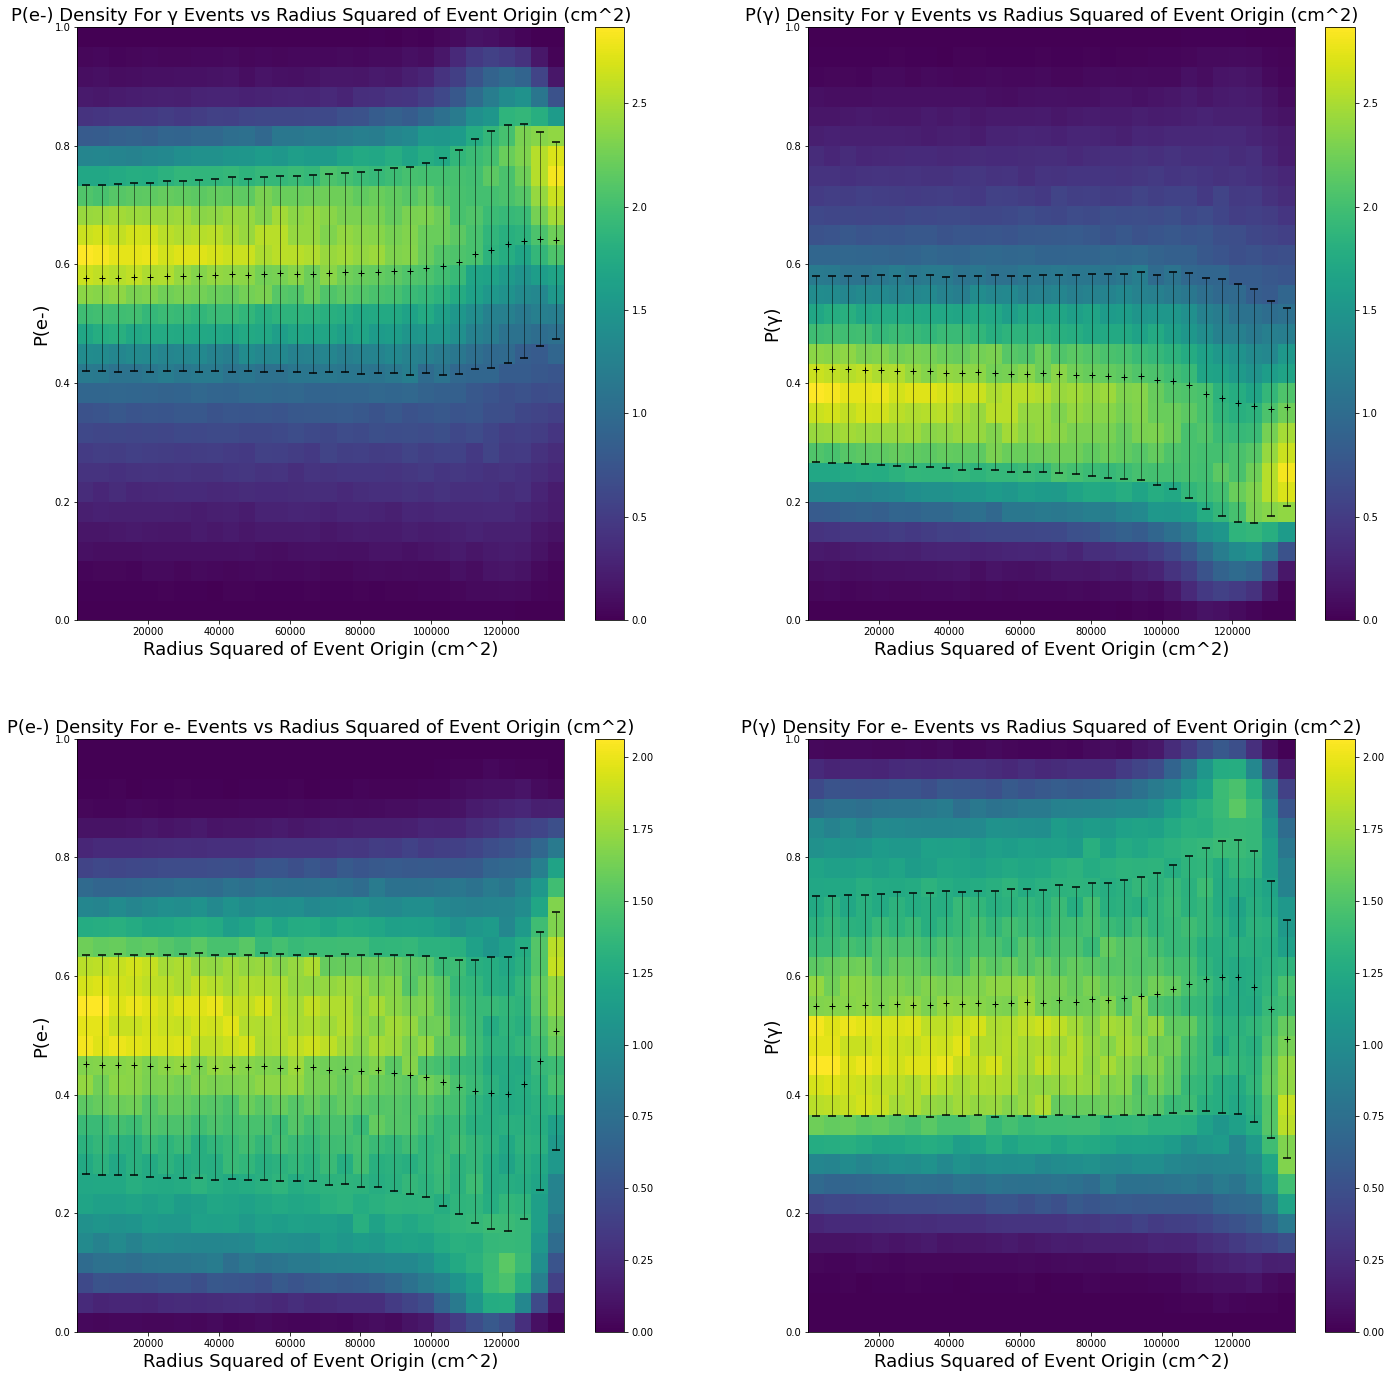

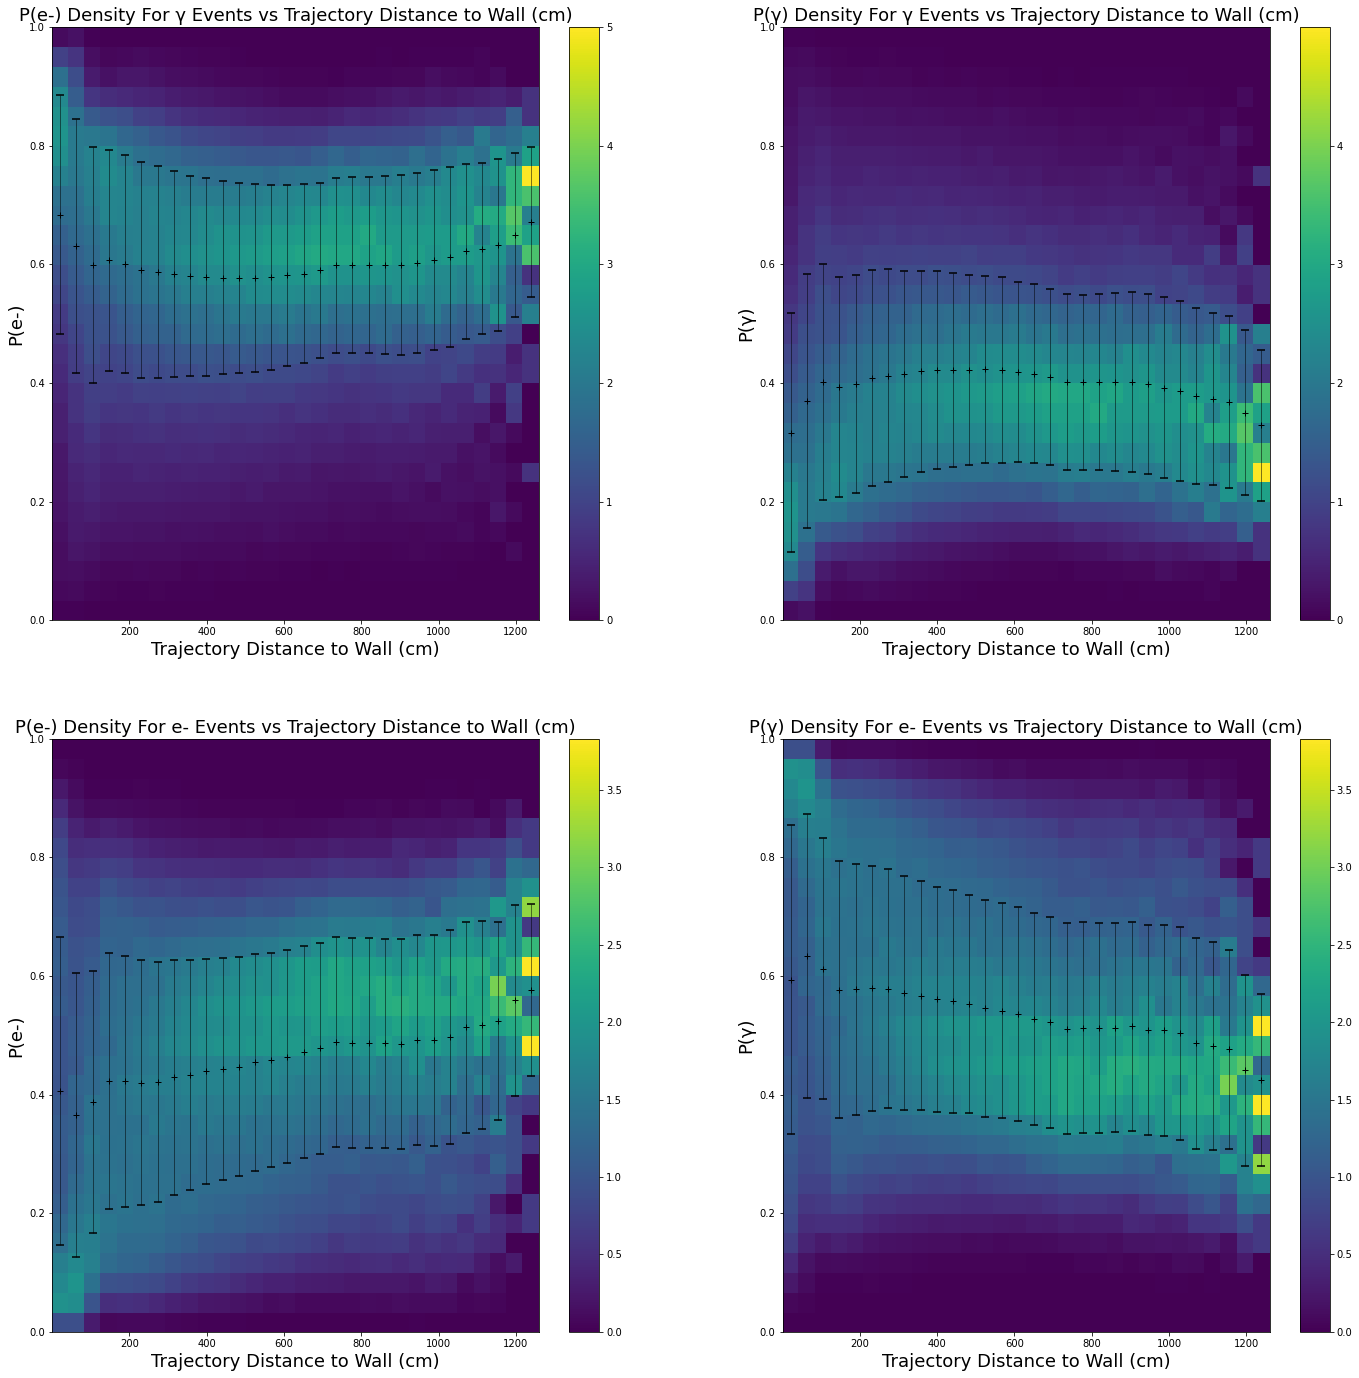

In [30]:
img_names = ['2d_resnet_binned_response_energy.pdf','2d_resnet_binned_response_radius.pdf','2d_resnet_binned_response_dtowall.pdf']
for i in range(len(binning_features)):
    fig = plot_binned_response(preferred_run['softmax'],
            preferred_run['labels'],
            ['e','gamma'],
            binning_features[i],           
            binning_labels[i],
            0.8, 30, 30,softmax_index_dict,
            legend_label_dict=legend_label_dict
            )
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i])) 